<head>
    <style>
        .md-typeset h2 {
            margin:0;
            }
        .md-typeset h3 {
            margin:0;
            }
        .jupyter-wrapper table.dataframe tr, .jupyter-wrapper table.dataframe th, .jupyter-wrapper table.dataframe td {
            text-align:left;
            }
        .jupyter-wrapper table.dataframe {
            table-layout: auto;
            }
    </style>
    <script type="text/javascript" id="MathJax-script" async 
    src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js">
    </script>
</head>

# 4 Linear Methods for Classification

## 4.1 Introduction 

Since our predictor $G(x)$ takes values in a discrete set $\mathcal{G}$, we can always divide the input space into a collection of regions labeled according to the classification. We saw in Chapter 2 that the boundaries of these regions can be rough or smooth, depending on the prediction function. For an important class of procedures, these _decision boundaries_ are linear; this is what we it mean by linear methodds for classification.

To build the connection between features $X$ and __discrete__ outcomes, we 
could reply on _logit transformation_ as follows: 

\begin{align}
\text{Pr}(G=1|X=x) &= \frac{\exp(\beta_0+\beta^Tx)}{1+\exp(\beta_0+\beta^Tx)},\\
\text{Pr}(G=2|X=x) &= \frac{1}{1+\exp(\beta_0+\beta^Tx)},\\
\end{align}

where the monotone transformation is the *logit* transformation

$$
\log\frac{p}{1-p},
$$ 

and in fact we see that

\begin{equation}
\log\frac{\text{Pr}(G=1|X=x)}{\text{Pr}(G=2|X=x)} = \beta_0 + \beta^Tx.
\end{equation}

The decision boundary is the set of points for which the *log-odds* are zero, and this is a hyperplane defined by

$$
\left\lbrace x: \beta_0+\beta^Tx = 0 \right\rbrace.
$$

We will discuss two very popular but different methods that result in 
linear log-odds or logits: Linear discriminant analysis and linear 
logistic regression.

Once could also classify __discrete__ outcomes without using log likelihood
functions, which means we can explicitly model the boundaries between the
classes as linear. 

We will look at two methods that explicitly look for "separating hyperplanes".

1. The well-known perceptron model of Rosenblatt (1958), with an algorithm that finds a separating hyperplane in the training data, if one exists.
2. Vapnik (1996) finds an optimally separating hyperplane if one exists, else finds a hyperplane that minimizes some measure of overlap in the training data.

When a separating hyperplane could be found we say it is _linear classficiable_,
whereas we need to use _neural network_ to classifiy them. 

![figure4.1](https://yintingchou.com/posts/2017-03-13-lda-and-qda/ldaqda_1.png)

In [6]:
import math
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
%config InlineBackend.figure_format = 'svg'

## 4.2. Linear Regression of an Indicator Matrix

Here each of the response categories are coded via an indicator variable.
For example,

$$Y_3 = [0, 0, 1, 0, 0]$$
assuming we have 5 classes. This is also called _one-hot encoding_. 

Thus if $\mathcal{G}$ has $K$ classes, there will be $K$ such indicators $Y_k$, $k=1,\cdots,K$, with

$$
Y_k = 1 \text{ if } G = k \text{ else } 0.
$$

These are collected together in a vector $Y=(Y_1,\cdots,Y_k)$, and the $N$ training instances of these form an $N\times K$ *indicator response matrix* $\mathbf{Y}$, which is a matrix of $0$'s and $1$'s, with each row having a single $1$. 

For example,

$$
Y = \begin{bmatrix} 
    1 & 0 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0 & 0 \\
     & & \vdots & &  \\ 
    0 & 0 & 0 & 0 & 1
 \end{bmatrix}
$$

We fit a linear regression model to each of the columns of $\mathbf{Y}$ simultaneously, and the fit is given by

\begin{equation}
\hat{\mathbf{Y}} = \mathbf{X}\left(\mathbf{X}^T\mathbf{X}\right)^{-1}\mathbf{X}^T\mathbf{Y} = \mathbf{X}\hat{\mathbf{B}}.
\end{equation}

Note that we have a coefficient vector for each response columns $\mathbf{y}_k$, and hence a $(p+1)\times K$ coefficient matrix $\hat{\mathbf{B}} = \left(\mathbf{X}^T\mathbf{X}\right)^{-1}\mathbf{X}^T\mathbf{Y}$. Here $\mathbf{X}$ is the model matrix with $p+1$ columns with a leading columns of $1$'s for the intercept.

A new observation with input $x$ is classified as follows:
* Compute the fitted output $\hat{f}(x)^T = (1, x^T)^T\hat{\mathbf{B}}$, a $K$ vector.
* Identify the largest component and classify accordingly:  

\begin{equation}
\hat{G}(x) = \arg\max_{k\in\mathcal{G}} \hat{f}_k(x).
\end{equation}

###  Masked class with the regression approach

There is a serious problem with the regression approach when the number of class $K\ge 3$, especially prevalent when $K$ is large. Because of the rigid nature of the regression model, classes can be *masked* by others. FIGURE 4.2 illustrates an extreme situation when $K=3$. The three classes are perfectly separated by linear decision boundaries, yet linear regression misses the middle class completely.

In [7]:
def generate_data(sample_size, feature_size, cluster_means, cluster_cov):
    """
    sample size = n \\ 
    feature size = m \\ 
    classes are fixed = 3 or cluster = 3 ; 
    """
    # generate values for features x1 and x2 
    xx = np.random.multivariate_normal(
        cluster_means, cluster_cov, size=(sample_size, feature_size)
        ).flatten(order='F').reshape(-1, feature_size)
    # constant values
    const = np.ones((sample_size*3, 1))
    # stack all values 
    xmat = np.hstack(
        [const, xx]
        )
    # generate labels
    nplabel = np.repeat(
        ['c1', 'c2', 'c3'], sample_size).reshape(-1, 1)
    column_names = ['const']
    for i in range(feature_size):
        temp = 'x'+str(i+1)
        column_names.append(temp)
    sdata = pd.DataFrame(
        xmat,
        columns=column_names
    )
    sdata['class'] = nplabel
    
    ymat = pd.get_dummies(sdata['class'])
    
    return sdata, xmat, ymat

In [8]:
# generate three clusters
np.random.seed(789)
sample_mean = [-4, 0, 4]
sample_cov = np.eye(3)
sdata, xmat, ymat = generate_data(300, 2, sample_mean, sample_cov)
sdata.head()

const        x1        x2 class
0    1.0 -5.108111 -3.932767    c1
1    1.0 -4.425128 -2.733287    c1
2    1.0 -2.815007 -3.383044    c1
3    1.0 -1.927488 -3.286930    c1
4    1.0 -2.506928 -3.792087    c1

In [9]:
# one hot encoding
ymat.head()

c1  c2  c3
0   1   0   0
1   1   0   0
2   1   0   0
3   1   0   0
4   1   0   0

In [10]:
# fit linear regression
beta = np.linalg.solve(xmat.T @ xmat, xmat.T @ ymat)
beta

array([[ 0.33526599,  0.33314592,  0.33158809],
       [-0.05184917, -0.00616798,  0.05801715],
       [-0.06709384,  0.00617052,  0.06092332]])

In [11]:
def estimate_class(beta, xmat):
    y_est = xmat @ beta
    estimated_class = y_est.argmax(axis=1)+1
    estimated_class = estimated_class.astype('str')
    estimated_class = np.core.defchararray.add(
        np.array(['c']*900), estimated_class
        )
    
    return y_est, estimated_class

In [12]:
# calculate estimation 
y_est, estimated_class = estimate_class(beta, xmat)
y_est.shape

(900, 3)

So far, we have

* computed the fitted output $\hat{f}(x)^T = (1, x^T)^T\hat{\mathbf{B}}$, a $K$ vector.

Now, we will:

* Identify the largest component and classify accordingly:  

\begin{equation}
\hat{G}(x) = \arg\max_{k\in\mathcal{G}} \hat{f}_k(x).
\end{equation}

In [13]:
pd.Series(y_est.argmax(axis=1)).value_counts()

0    448
2    441
1     11
dtype: int64

Notice, that most of observations from class 2 are masked as either as class 1
or class 3. Now, we will plot the original dataset and estimated classes.  

In [14]:
sdata['est_class'] = estimated_class
sdata.head()

const        x1        x2 class est_class
0    1.0 -5.108111 -3.932767    c1        c1
1    1.0 -4.425128 -2.733287    c1        c1
2    1.0 -2.815007 -3.383044    c1        c1
3    1.0 -1.927488 -3.286930    c1        c1
4    1.0 -2.506928 -3.792087    c1        c1

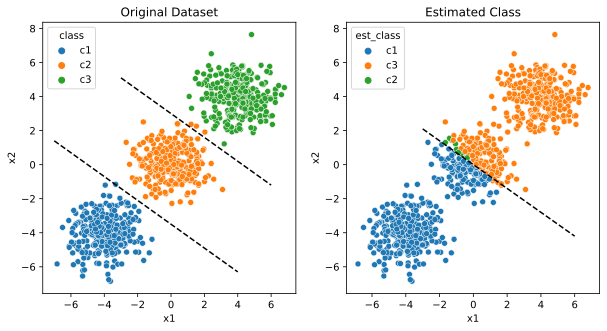

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(x='x1', y='x2', hue='class', 
                data=sdata, ax=axes[0]);
axes[0].set_title("Original Dataset")
sns.scatterplot(x='x1', y='x2', hue='est_class', 
                data=sdata, ax=axes[1]);
axes[1].set_title("Estimated Class");
# add boundary line
xx1 = np.linspace(-7, 4)
y1 = -0.7*xx1-3.5
axes[0].plot(xx1, y1, 'k--');
xx2 = np.linspace(-3, 6)
y2 = -0.7*xx2+3
axes[0].plot(xx2, y2, 'k--');
y3 = -0.7*xx2
axes[1].plot(xx2, y3, 'k--');

The three classes are perfectly separated by linear decision boundaries, 
yet linear regression misses the middle class completely. Now, we will
generate another dataset that each observation has only one feature $x_1$. 

In [16]:
# figure 4.3 another example of masking class
# with one feature
np.random.seed(234)
sdata2, xmat2, ymat2 = generate_data(300, 1, sample_mean, sample_cov)
sdata2.head()

const        x1 class
0    1.0 -3.181208    c1
1    1.0 -3.078422    c1
2    1.0 -4.969733    c1
3    1.0 -2.574784    c1
4    1.0 -5.283554    c1

In [17]:
# linear regression with degree 1 
beta_degree1 = np.linalg.solve(xmat2.T @ xmat2, xmat2.T @ ymat2)
beta_degree1

array([[ 3.33554011e-01,  3.33332814e-01,  3.33113175e-01],
       [-1.12992566e-01,  2.65736676e-04,  1.12726830e-01]])

In [18]:
# fit with linear regression of degree 1 and degree 2 
xmat2_sqr = np.hstack([xmat2, xmat2[:, 1:] * xmat2[:, 1:]])
beta_degree2 = np.linalg.solve(xmat2_sqr.T @ xmat2_sqr, xmat2_sqr.T @ ymat2)
beta_degree2

array([[ 0.12511596,  0.75642206,  0.11846198],
       [-0.11246881, -0.0007974 ,  0.1132662 ],
       [ 0.01739609, -0.03531073,  0.01791463]])

In [19]:
y_est1, estimated1 = estimate_class(beta_degree1, xmat2)
sdata2['est_degree1'] = estimated1
y_est2, estimated2 = estimate_class(beta_degree2, xmat2_sqr)
sdata2['est_degree2'] = estimated2
sdata2.head()

const        x1 class est_degree1 est_degree2
0    1.0 -3.181208    c1          c1          c1
1    1.0 -3.078422    c1          c1          c1
2    1.0 -4.969733    c1          c1          c1
3    1.0 -2.574784    c1          c1          c1
4    1.0 -5.283554    c1          c1          c1

In [20]:
pd.Series(y_est1.argmax(axis=1)).value_counts()

0    453
2    447
dtype: int64

In [21]:
pd.Series(y_est2.argmax(axis=1)).value_counts()

1    333
2    285
0    282
dtype: int64

We can see that the quadratic regression solve the masking issue. 

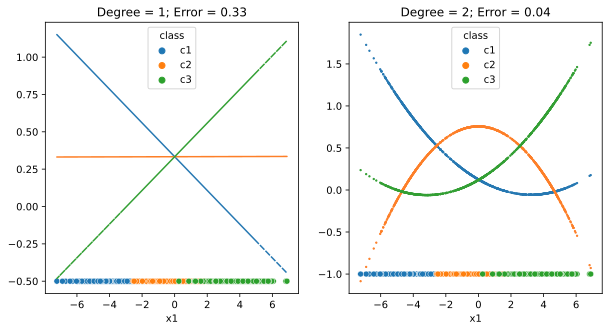

In [22]:
# plot the results
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(
    x='x1', y=-0.5,  hue='class', data=sdata2, ax=axes[0]
)
axes[0].plot(xmat2[:, 1], y_est1[:, 0], 
             color='#2678B2', linestyle='dashed')
axes[0].plot(xmat2[:, 1], y_est1[:, 1], 
             color='#FD7F28', linestyle='dashed')
axes[0].plot(xmat2[:, 1], y_est1[:, 2], 
             color='#339F34', linestyle='dashed')
axes[0].set_title('Degree = 1; Error = 0.33')
sns.scatterplot(
    x='x1', y=-1,  hue='class', data=sdata2, ax=axes[1]
)
axes[1].scatter(xmat2[:, 1], y_est2[:, 0], 
             color='#2678B2', s=2)
axes[1].scatter(xmat2[:, 1], y_est2[:, 1], 
             color='#FD7F28', s=2)
axes[1].scatter(xmat2[:, 1], y_est2[:, 2], 
             color='#339F34', s=2)
axes[1].set_title('Degree = 2; Error = 0.04');

In [23]:
# get predicted class
sdata2['y_pred1'] = np.max(y_est1, axis=1)
sdata2['y_pred2'] = np.max(y_est2, axis=1)
sdata2.head()

const        x1 class est_degree1 est_degree2   y_pred1   y_pred2
0    1.0 -3.181208    c1          c1          c1  0.693007  0.658953
1    1.0 -3.078422    c1          c1          c1  0.681393  0.636200
2    1.0 -4.969733    c1          c1          c1  0.895097  1.113709
3    1.0 -2.574784    c1          c1          c1  0.624486  0.530027
4    1.0 -5.283554    c1          c1          c1  0.930556  1.204979

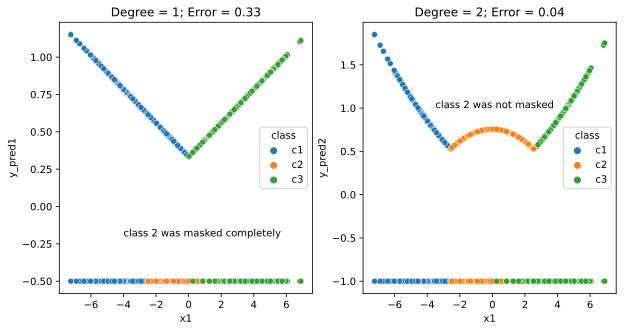

In [24]:
# now we plot the results again
# plot the results
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(
    x='x1', y=-0.5,  hue='class', data=sdata2, 
    palette=['#2678B2', '#FD7F28', '#339F34'],
    ax=axes[0]
)
sns.scatterplot(
    x='x1', y='y_pred1', hue='est_degree1', data=sdata2, 
    legend=False,
    palette=['#2678B2', '#339F34'],
    ax=axes[0]
)
axes[0].set_title('Degree = 1; Error = 0.33')
axes[0].annotate('class 2 was masked completely',
                 (-4, -0.2));
sns.scatterplot(
    x='x1', y=-1,  hue='class', data=sdata2, ax=axes[1]
)
sns.scatterplot(
    x='x1', y='y_pred2', hue='est_degree2', data=sdata2, 
    legend=False,
    ax=axes[1]
)
axes[1].annotate('class 2 was not masked',
                 (-3.5, 1));
axes[1].set_title('Degree = 2; Error = 0.04');

For this simple example a quadratic rather than linear fit would solve the problem. 
However, if there were 4 classes, a quadratic would not come down 
fast enough, and a cubic would be needed as well. A loose but 
general rule is that if $K\ge 3$ classes are lined up, polynomial 
terms up to degree $K-1$ might be needed to resolve them.

Note also that these are polynomials along the derived direction 
passing through the centroids, which can have orbitrary orientation. 
So in $p$-dimensional input space, one would need general polynomial 
terms and cross-products of total degree $K-1$, $O(p^{K-1})$ terms 
in all, to resolve such worst-case scenarios.

The example is extreme, but for large $K$ and small $p$ such maskings 
naturally occur. As a more realistic illustration, FIGURE 4.4 is
 a projection of the training data for a vowel recognition problem 
 onto an informative two-dimensional subspace.

In [25]:
# figure 4.4
vowel = pd.read_csv('./data/vowel/vowel.train', index_col=0)
vowel.head()

y    x.1    x.2    x.3    x.4    x.5    x.6    x.7    x.8    x.9  \
row.names                                                                     
1          1 -3.639  0.418 -0.670  1.779 -0.168  1.627 -0.388  0.529 -0.874   
2          2 -3.327  0.496 -0.694  1.365 -0.265  1.933 -0.363  0.510 -0.621   
3          3 -2.120  0.894 -1.576  0.147 -0.707  1.559 -0.579  0.676 -0.809   
4          4 -2.287  1.809 -1.498  1.012 -1.053  1.060 -0.567  0.235 -0.091   
5          5 -2.598  1.938 -0.846  1.062 -1.633  0.764  0.394 -0.150  0.277   

            x.10  
row.names         
1         -0.814  
2         -0.488  
3         -0.049  
4         -0.795  
5         -0.396

In [26]:
df_y = vowel['y']
df_x2d = vowel[['x.1', 'x.2']]
grouped = df_x2d.groupby(df_y)

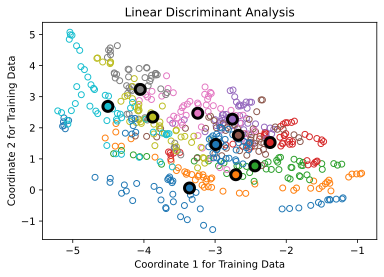

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for y, x in grouped:
    x_mean = x.mean()  # mean of (x1 and x2) for each group 
    color = next(ax._get_lines.prop_cycler)['color']
    ax.scatter(x['x.1'], x['x.2'], 
               edgecolor=color, facecolors='none')
    ax.plot(x_mean[0], x_mean[1], 'o', color=color, markersize=10,
            markeredgecolor='black', markeredgewidth=3)
ax.set_xlabel('Coordinate 1 for Training Data')
ax.set_ylabel('Coordinate 2 for Training Data')
ax.set_title('Linear Discriminant Analysis');

There are K = 11 classes in p = 10 dimensions. This is a difficult 
classification problem, and the best methods achieve around 40% errors 
on the test data. The main point here is summarized in Table 4.1; 
linear regression has an error rate of 67%, while a close relative, 
linear discriminant analysis, has an error rate of 56%. It seems 
that masking has hurt in this case. While all the other methods 
in this chapter are based on linear functions of x as well, they 
use them in such a way that avoids this masking problem.

| Technique                       | Error Rate        |
|---------------------------------|------------|------|
|                                 | Training   | Test |
| Linear regression               | 0.48       | 0.67 |
| Linear discriminant analysis    | 0.32       | 0.56 |
| Quadratic discriminant analysis | 0.01       | 0.53 |
| Logistic regression             | 0.22       | 0.51 |

To summarize, there are at least two reasons not to perform classification using a regression method: 

- (a) a regression method cannot accommodate a qualitative response with more than two classes; 
- (b) a regression method will not provide meaningful estimates of $Pr(Y|X)$, even with just two classes.

## 4.3. Linear Discriminant Analysis

Decision theory for classification tells us that we need to know the class 
posteriors _mass_ function $\text{Pr}(G|X)$ for optimal classification. Suppose

* $f_k(x)$ is the class-conditional density of $X$ in class $G=k$,
* $\pi_k$ is the prior probability of class $k$, with $\sum\pi_k=1$.

A simple application of Bayes theorem gives us

\begin{equation}
\text{Pr}(G=k|X=x) = \frac{f_k(x)\pi_k}{\sum_{l=1}^K f_l(x)\pi_l}.
\end{equation}

We see that in terms of ability to classify, it is enough to have the $f_k(x)$. Many techniques are based on models for the class densities:

* linear and quadratic discriminant analysis use Gaussian densities;
* more flexible mixtures of Gaussian allow for nonlinear decision 
boundaries ($\S$ 6.8);
* general nonparametric density estimates for each class density allow 
the most flexibility ($\S$ 6.6.2);
* *Naive Bayes* models are a variant of the previous case, and assume that 
the inputs are conditionally independent in each class; i.e., each of 
the class densities are products of marginal densities ($\S$ 6.6.3).

Suppose that we model each class density as multivariate Gaussian

\begin{equation}
f_k(x) = \frac{1}{(2\pi)^{p/2}|\Sigma_k|^{1/2}}\exp\left\lbrace -\frac{1}{2}(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k) \right\rbrace
\end{equation}

where $p$ is the number of feature dimension. 

Linear discriminant analysis (LDA) arises in the special case when we assume that the classes have a common covariance matrix $\Sigma_k=\Sigma,\forall k$.

In comparing two classes $k$ and $l$, it is sufficient to look at the log-ratio, and we see that as an equation linear in $x$,

\begin{aligned}
\log\frac{\text{Pr}(G=k|X=x)}{\text{Pr}(G=l|X=x)} &= \log\frac{f_k(x)}{f_l(x)} + \log\frac{\pi_k}{\pi_l} \\
&= \log\frac{\pi_k}{\pi_l} - \frac{1}{2}\mu_k^T\Sigma^{-1}\mu_k + \frac{1}{2}\mu_l^T\Sigma^{-1}\mu_l + x^T\Sigma^{-1}(\mu_k-\mu_l) \\
&= \delta_k(x) - \delta_l(x),
\end{aligned}

where $\delta_k$ is the *linear discriminant function*

\begin{equation}
\delta_k(x) = x^T\Sigma^{-1}\mu_k - \frac{1}{2}\mu_k^T\Sigma^{-1}\mu_k + \log\pi_k.
\end{equation}

This linear log-odds function implies that the decision boundary between classes $k$ and $l$

\begin{equation}
\left\lbrace x: \delta_k(x) - \delta_l(x) = 0 \right\rbrace
\end{equation}

is linear in $x$; in $p$ dimensions a hyperplane. Also the linear discriminant functions are equivalent description of the decision rule, with

\begin{equation}
G(x) = \arg\max_k \delta_k(x).
\end{equation}

In [28]:
## why the decision boundary between classes k and l implies
## delta_k(x) - delta_l(x) = 0 
## if the posterior pk > pl, then classified it as k
np.random.seed(889)
pk = np.random.uniform(0, 1, 100)
pl = np.random.uniform(0, 1, 100)
odds_ratio = pk/pl
cls_kl = np.where(odds_ratio > 1, 'class-k', 'class-l')
boundary_data = pd.DataFrame(
    [pk, pl, odds_ratio, cls_kl]
)
boundary_data = boundary_data.transpose()
boundary_data.columns = ['pk', 'pl', 'odds_ratio', 'classification']
boundary_data.head()


pk        pl odds_ratio classification
0  0.428559  0.444959   0.963144        class-l
1  0.807978  0.875746   0.922616        class-l
2  0.749596  0.364627   2.055786        class-k
3  0.405277  0.922467    0.43934        class-l
4  0.274735   0.40617   0.676402        class-l

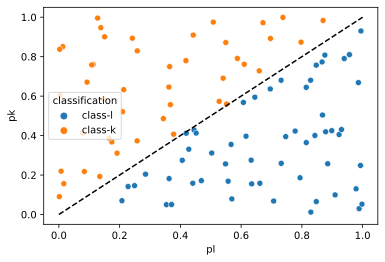

In [29]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
sns.scatterplot(
    x='pl', y='pk', hue='classification',
    data=boundary_data, ax=axes
    )
xx = np.linspace(0, 1, 100)
axes.plot(xx, xx, 'k--');

The figure above shows why we set decision boundary between classes $k$ and $l$

\begin{equation}
\left\lbrace x: \delta_k(x) - \delta_l(x) = 0 \right\rbrace
\end{equation}

as $log 1 = 0 $. 

<div class="admonition note">
<p class=admonition-title>Note</p> 
<p>
For LDA, bayesian estimation and maximum likelihood estimation are equivament.  
</p> 
</div>

That's why we have the following decision rule too:

\begin{equation}
G(x) = \arg\max_k \delta_k(x).
\end{equation}

In [30]:
# figure 4.5, a simulated example
np.random.seed(666)
sample_size = 30
sample_mean = [-0.5, 0, 0.5]
# generate a positive semidefinite matrix
rand_mat = np.random.rand(3, 3)
sample_cov = rand_mat.T @ rand_mat / 10
sdata3, xmat3, ymat3 = generate_data(
    sample_size, 2, sample_mean, sample_cov
)
# now we will shift x2 down 
sdata3['x2roll'] = np.roll(sdata3['x2'], 30)
sdata3.head()

const        x1        x2 class    x2roll
0    1.0 -0.071273 -0.182977    c1  0.466982
1    1.0 -0.670211 -0.320429    c1  0.441147
2    1.0 -0.800962 -0.615667    c1  0.274339
3    1.0 -0.691924 -0.543417    c1  0.713403
4    1.0 -0.598135 -0.498490    c1  0.492381

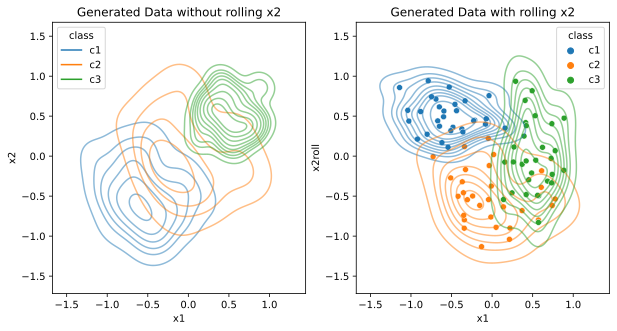

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.kdeplot(
    x='x1', y='x2', hue='class', alpha=0.5,
    data=sdata3, ax=axes[0]
    )
axes[0].set_title('Generated Data without rolling x2')
sns.move_legend(axes[0], 'upper left')  # move legend 
sns.kdeplot(
    x='x1', y='x2roll', hue='class', alpha=0.5,
    data=sdata3, ax=axes[1]
    )
sns.scatterplot(
    x='x1', y='x2roll',  hue='class', data=sdata3, ax=axes[1]
    )
axes[1].set_title('Generated Data with rolling x2');

Now, we will estimate the class via the _linear discriminant functions_:

$$
\delta_k(x) = x^T\Sigma^{-1}\mu_k - \frac{1}{2}\mu_k^T\Sigma^{-1}\mu_k + \log\pi_k.
$$ 

In practice we do not know the parameters of the Gaussian distributions, and will need to estimate them using our training data:
* $\hat\pi_k = N_k/N$,
* $\hat\mu_k = \sum_{g_i = k} x_i/N_k$;
* $\hat\Sigma = \sum_{k=1}^K \sum_{g_i=k}(x_i-\hat\mu_k)(x_i-\hat\mu_k)^T/(N-K)$.



In [32]:
## chose 80% of sdata3 as tranning dataset
training_data = sdata3.sample(frac=0.8)
# estimate prior, mean and variance
prior_hat = (training_data.groupby(
    ['class']
    ).count()/training_data.shape[0])['const']
prior_hat

class
c1    0.361111
c2    0.305556
c3    0.333333
Name: const, dtype: float64

In [33]:
# estimate mean
mean_hat = training_data.groupby(
    ['class']
    ).mean()[['x1', 'x2roll']]
mean_hat

x1    x2roll
class                    
c1    -0.542296  0.518047
c2     0.020427 -0.556884
c3     0.507638  0.013990

In [34]:
# calcluate covariance for each group 
cov_each_group = training_data.groupby(
    ['class']
    )[['x1', 'x2roll']].cov()
cov_each_group

x1    x2roll
class                           
c1    x1      0.110910 -0.009916
      x2roll -0.009916  0.042135
c2    x1      0.147984 -0.025898
      x2roll -0.025898  0.101976
c3    x1      0.032246 -0.016600
      x2roll -0.016600  0.209065

In [35]:
# calculate the average covariance
cov_hat = (cov_each_group.loc['c1'] + cov_each_group.loc['c2'] + 
            cov_each_group.loc['c3'])/(training_data.shape[0]-3)
cov_hat

x1    x2roll
x1      0.004219 -0.000760
x2roll -0.000760  0.005118

With the following formula:

$$
\delta_k(x) = x^T\Sigma^{-1}\mu_k - \frac{1}{2}\mu_k^T\Sigma^{-1}\mu_k + \log\pi_k.
$$ 


In [36]:
np.linalg.inv(cov_hat)

array([[243.50634645,  36.13821796],
       [ 36.13821796, 200.73295574]])

In [37]:
prior_hat

class
c1    0.361111
c2    0.305556
c3    0.333333
Name: const, dtype: float64

In [38]:
# calculate linear discriminant scores
# x.shape = 1x2, covariance is 2x2 mean_hat should be 2x1
print(
    f"X shape: {xmat3[:, 1:].shape}",
    f"Cov shape: {cov_hat.shape}",
    f"Mean shape: {mean_hat.shape}",
    sep='\n'
    )

X shape: (90, 2)
Cov shape: (2, 2)
Mean shape: (3, 2)


In [39]:
def discriminant_score(x_feature_vector):
    """
    In our case, feature dimension p=2, but class dimenion K=3 \\ 
    x_feature_vector shape = 1 x 2 \\
    cov_mat = 2 x 2 \\ 
    mean_hat shape = 2 x 1 
    """
    cov_inv = np.linalg.inv(cov_hat)
    mean_c1 = mean_hat.loc['c1'].values.reshape(2, 1)
    mean_c2 = mean_hat.loc['c2'].values.reshape(2, 1)
    mean_c3 = mean_hat.loc['c3'].values.reshape(2, 1)
    c1 = (
        x_feature_vector @ cov_inv @ mean_c1 - 
        1/2 * mean_c1.T @ cov_inv @ mean_c1 +
        np.log(prior_hat['c1'])
    )
    c2 = (
        x_feature_vector @ cov_inv @ mean_c2 - 
        1/2 * mean_c2.T @ cov_inv @ mean_c2 +
        np.log(prior_hat['c2'])
    )
    c3 = (
        x_feature_vector @ cov_inv @ mean_c3 - 
        1/2 * mean_c3.T @ cov_inv @ mean_c3 +
        np.log(prior_hat['c3'])
    )

    return [c1[0], c2[0], c3[0]]
    

In [40]:
# extrat features
xmat_features = training_data[['x1', 'x2roll']]
xmat_features.head()

x1    x2roll
54  0.020254  0.020241
88  0.421421  0.381563
51  0.571343 -0.797902
73  0.289732  0.936149
21 -0.080530  0.400724

In [41]:
# test the discriminant function
discriminant_score(
    xmat_features.iloc[1, :].values.reshape(1, 2)
)  # indeed, it gives the high score for c1

[array([-69.16687308]), array([-80.70709791]), array([27.62736642])]

Now, we will classify our trainning dataset calculate the accuracy. Then we will
use the test dataset to test linear discriminant classification. 

In [42]:
# estimate the class
y_est = np.apply_along_axis(discriminant_score, 1, xmat_features)
estimated_class = y_est.argmax(axis=1)+1
estimated_class = estimated_class.astype('str')
estimated_class = np.core.defchararray.add(
        np.array(['c']), estimated_class
        )
estimated_class
training_data['estimated_class'] = estimated_class
training_data.head()

const        x1        x2 class    x2roll estimated_class
54    1.0  0.020254  0.475237    c2  0.020241              c3
88    1.0  0.421421  0.857843    c3  0.381563              c3
51    1.0  0.571343 -0.334370    c2 -0.797902              c2
73    1.0  0.289732  0.648200    c3  0.936149              c3
21    1.0 -0.080530 -0.797902    c1  0.400724              c1

In [43]:
# calculate accuracy
sum(
    training_data['class'] == training_data['estimated_class']
    ) / training_data.shape[0]

0.875

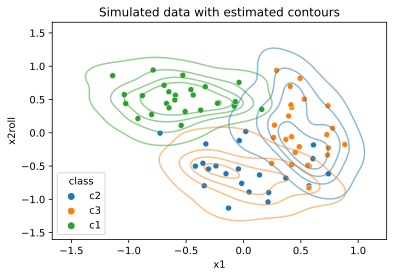

In [44]:
# now we will plot the simulated dataset and estimated results
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
sns.kdeplot(
    x='x1', y='x2roll', hue='estimated_class', alpha=0.5,
    levels=5, 
    data=training_data, ax=axes
    )
sns.scatterplot(
    x='x1', y='x2roll', hue='class', 
    data=training_data, ax=axes
    )
sns.move_legend(axes, 'lower left')
axes.set_title('Simulated data with estimated contours');

In [45]:
training_data.head()

const        x1        x2 class    x2roll estimated_class
54    1.0  0.020254  0.475237    c2  0.020241              c3
88    1.0  0.421421  0.857843    c3  0.381563              c3
51    1.0  0.571343 -0.334370    c2 -0.797902              c2
73    1.0  0.289732  0.648200    c3  0.936149              c3
21    1.0 -0.080530 -0.797902    c1  0.400724              c1

<div class='admonition note'> 
<p class='admonition-title'> Note </p>
<p> 
LDA is equiavlent to linear regression with two classes (K=2). However, when
K > 3, LDA is not the same as linear regression of the class indicator matrix, 
and it avoids the masking problems. 
</p>
</div>

### Quadratic discriminant analysis

When we assume the _covariance_ is different for each class, then based 
on the following equation

$$
f_k(x) = \frac{1}{(2\pi)^{p/2}|\Sigma_k|^{1/2}}\exp\left\lbrace -\frac{1}{2}(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k) \right\rbrace
$$ 

the convenient cancellations do not occur. We then get _quadratic discriminant functions_ (QDA),

\begin{equation}
\delta_k(x) = -\frac{1}{2}\log|\Sigma_k| -\frac{1}{2}(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k) + \log\pi_k
\end{equation}

The decision boundary between each pair of classes $k$ and $l$ is described by a quadratic equation $\left\lbrace x: \delta_k(x) = \delta_l(x) \right\rbrace$.

The estimates for QDA are similar to those for LDA, except that _separate
covariance matrices_ must be estimated for each class. When p is large this
can mean a dramatic increase in parameters. Since the decision boundaries
are functions of the parameters of the densities, counting the number of
parameters must be done with care. For LDA, it seems there are $(K −
1) × (p + 1)$ parameters. Likewise for QDA there will be $(K-1) \times \{p(p+3)/2+1\}$
parameters. Both LDA and QDA perform well on an amazingly large and diverse set
of classification tasks.

For a problem with $K$ classes, we could only need $K-1$ discriminant functions
by arbitrarily choosing one class to be the base class. Then, the total number of
estimated parameters for LDA is $(K-1)(p+1)$. However, for QDA, for each class $K$

- number of means to be estimated: $p$
- number of covariance to be estimated $p(p+1)/2$
- number of class prior to be estimated $1$

The total number of estimated parameters is $(K-1) \times \{p(p+3)/2+1\}$

Therefore, _the number of parameters estimated in LDA increases linearly with p 
while that of QDA increases quadratically with p_. We would expect QDA to 
have worse performance than LDA when the dimension p is large.

Both techniques are widely used, and entire books
are devoted to LDA. _It seems that whatever exotic tools are the rage of the
day, we should always have available these two simple tools_. The question
arises why LDA and QDA have such a good track record. The reason is not
likely to be that the data are approximately Gaussian, and in addition for
LDA that the covariances are approximately equal. More likely a reason is
that the data can only support simple decision boundaries such as linear or
quadratic, and the estimates provided via the Gaussian models are stable.
This is a bias variance tradeoff—we can put up with the bias of a linear
decision boundary because it can be estimated with much lower variance
than more exotic alternatives.

### Regularized Discriminant Analysis

We can find a compromise between LDA and QDA by regularizing the individual 
class covariance matrices. Regularization means that we put a certain 
restriction on the estimated parameters. In this case, we require that 
individual covariance matrix shrinks toward a common pooled covariance 
matrix through a penalty parameter $\alpha$:

$$\hat{\Sigma}_k (\alpha) = \alpha \hat{\Sigma}_k  + (1-\alpha) \hat{\Sigma}$$

where $\hat{\Sigma}$ is the pooled covariance matrix as used in LDA. The pooled covariance 
matrix can also be regularized toward an identity matrix through a penalty 
parameter $\gamma$

$$\hat{\Sigma} (\gamma) = \gamma \hat{\Sigma}  + (1-\gamma) \sigma^2 I$$

In situations where the number of input variables greatly exceeds the number 
of samples ($p>N$), the covariance matrix can be poorly estimated. Shrinkage can 
hopefully improve estimation and classification accuracy. 


In [46]:
class DiscriminantAnalysis():
    """
    Class for implimenting Regularized Discriminent Analysis
    LDA is performed when alpha=0
    QDA is performed when alpha=1
    Linear, Quadratic and Regularized discriminant analysis.
    Regularized discriminant analysis is a compromise between
    linear discrimenent analysis and quadratic discrimenent analysis.
    If you wish to add the constraint that the covariance matrix be
    diagonal (independent features), use Naive Bayes instead.
    Reference: https://github.com/christopherjenness/ML-lib
    """

    def __init__(self, alpha=1.0) -> None:
        self.is_model_fitted = False
        self.alpha = alpha
        self.class_categories = []
        self.class_priors = {}
        self.class_means = {}
        self.regularized_covariances = {}

    def fit(self, X, y):
        """
        X: N by p matrix
        y: N by 1 matrix 
        """
        # get unique classes 
        self.class_categories = np.unique(y)   
        # initialize the covariance 
        class_k_covs = {}
        pooled_covs = 0
        # estimate parameters: mean, covariance matrix and priors 
        for k in self.class_categories:
            class_k_idx = np.where(y==k)[0]
            class_k_features = X[class_k_idx, :]
            self.class_priors[k] = float(len(class_k_idx)) / y.shape[0]
            self.class_means[k] = np.mean(class_k_features, axis=0)
            # each column as a variable 
            class_k_covs[k] = np.cov(class_k_features, rowvar=False)
            # calculate pooled covariance
            # alternative formula: pooled_covs += class_k_covs[k]
            # pooled_covs = pooled_covs / (N-K)
            pooled_covs += class_k_covs[k] * self.class_priors[k]

        # calculate regularized covariance matrices for each class
        # when alpha = 1, it is LDA, pooled covs is not used
        for k in self.class_categories:
            self.regularized_covariances[k] = (
                self.alpha * class_k_covs[k] + 
                                (1-self.alpha) * pooled_covs
                )
        self.is_model_fitted = True

    def predict(self, X):
        """
        X: sample size by p matrix [sample_size, p]
        return: the predicted class [sample_size, 1] matrix
        """
        y_est = np.apply_along_axis(
            self.__classify, 1, X
        )

        return y_est


    def __classify(self, x):
        """
        Private method
        x: feature vector for one observation [1, p] dimension
        Returns: classified category
        """
        if not self.is_model_fitted:
            raise NameError('Please fit the model first')
        # calculate the determinant score
        classified_scores = {}
        for k in self.class_categories:
            mean_deviation = x-self.class_means[k]
            # pinv is preferred becuase of erros of float (sigularity)
            cov_inv = np.linalg.pinv(self.regularized_covariances[k])
            # use the formula in the equation (1)
            # for score1, we do not use np.log() as it might have 0s
            score1 = -0.5 * np.linalg.det(
                self.regularized_covariances[k]
                )
            score2 = -0.5 * mean_deviation.T @ cov_inv @ mean_deviation
            score3 = np.log(self.class_priors[k])

            classified_scores[k] = score1 + score2 + score3 

        # foo = {'a': 1, 'b': 3000, 'c': 0}
        # print(max(foo, key=foo.get)) 
        return max(classified_scores, key=classified_scores.get)

In [47]:
# figure 4.7
# read vowel train
vowel = pd.read_csv('./data/vowel/vowel.train', index_col=0)
vowel.head()

y    x.1    x.2    x.3    x.4    x.5    x.6    x.7    x.8    x.9  \
row.names                                                                     
1          1 -3.639  0.418 -0.670  1.779 -0.168  1.627 -0.388  0.529 -0.874   
2          2 -3.327  0.496 -0.694  1.365 -0.265  1.933 -0.363  0.510 -0.621   
3          3 -2.120  0.894 -1.576  0.147 -0.707  1.559 -0.579  0.676 -0.809   
4          4 -2.287  1.809 -1.498  1.012 -1.053  1.060 -0.567  0.235 -0.091   
5          5 -2.598  1.938 -0.846  1.062 -1.633  0.764  0.394 -0.150  0.277   

            x.10  
row.names         
1         -0.814  
2         -0.488  
3         -0.049  
4         -0.795  
5         -0.396

In [48]:
# read vowel test 
vowel_test = pd.read_csv('./data/vowel/vowel.test', index_col=0)
vowel_test.head()

y    x.1    x.2    x.3    x.4    x.5    x.6    x.7    x.8    x.9  \
row.names                                                                     
1          1 -1.149 -0.904 -1.988  0.739 -0.060  1.206  0.864  1.196 -0.300   
2          2 -2.613 -0.092 -0.540  0.484  0.389  1.741  0.198  0.257 -0.375   
3          3 -2.505  0.632 -0.593  0.304  0.496  0.824 -0.162  0.181 -0.363   
4          4 -1.768  1.769 -1.142 -0.739 -0.086  0.120 -0.230  0.217 -0.009   
5          5 -2.671  3.155 -0.514  0.133 -0.964  0.234 -0.071  1.192  0.254   

            x.10  
row.names         
1         -0.467  
2         -0.604  
3         -0.764  
4         -0.279  
5         -0.471

In [49]:
alpha_values = np.linspace(0, 1, 50)
train_mis_rate = []
test_mis_rate = []
# construct x and y
vowel_X = vowel.iloc[:, 1:].values
vowel_y = vowel.iloc[:, 0].values.reshape(-1, 1)
vowel_test_X = vowel_test.iloc[:, 1:].values

for alpha in alpha_values:
    vowel_rda = DiscriminantAnalysis(alpha)
    vowel_rda.fit(vowel_X, vowel_y)
    y_pred = vowel_rda.predict(vowel_X)
    # accuracy rate
    acc_rate = sum(vowel['y'] == y_pred) / vowel.shape[0]
    train_mis_rate.append(1-acc_rate)
    y_pred = vowel_rda.predict(vowel_test_X)
    acc_rate = sum(vowel_test['y'] == y_pred) / vowel_test.shape[0]
    test_mis_rate.append(1-acc_rate)

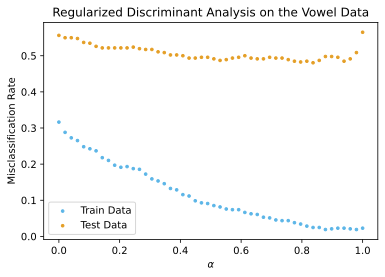

In [50]:
# figure 4.7 
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
axes.scatter(
    alpha_values, train_mis_rate, 
    color='#5BB5E7', s=7, label='Train Data'
    )
axes.scatter(
    alpha_values, test_mis_rate, 
    color='#E49E25', s=7, label='Test Data'
    )
axes.set_title("Regularized Discriminant Analysis on the Vowel Data")
axes.set_ylabel("Misclassification Rate")
axes.set_xlabel(r"$\alpha$")
axes.legend();


Figure 4.7 shows the results of RDA applied to the vowel data. Both the 
training and test error improve with increasing $\alpha$, although the test
error increases sharply after $\alpha = 0.9$. The large discrepancy between 
the training and test error is partly due to the fact that there are many 
repeat measurements on a small number of individuals, 
different in the training and test set.

In situations where the number of input variables greatly exceeds 
the number of samples ($p > N$), the covariance matrix can be 
poorly estimated. Shrinkage can hopefully improve estimation and 
classification accuracy. This is illustrated by the figure below.

In [51]:
def generate_data(n_samples, n_features):
    """
    Generate random blob-ish data with noisy features. 
    K = 2, p = n_features 
    
    Only one feature contains discriminative information
    
    The other features contain only noise.
    """
    X, y = make_blobs(n_samples=n_samples, n_features=1, centers=[[-2], [2]])

    # add non-discriminative features
    if n_features > 1:
        X = np.hstack([X, np.random.randn(n_samples, n_features - 1)])
    return X, y

In [52]:
n_train = 20  # samples for training
n_test = 200  # samples for testing
n_simulation = 30  # number of simulation 
n_features_max = 75  # maximum number of features
step = 4  # step size for the calculation

acc_clf1, acc_clf2 = [], []
n_features_range = range(1, n_features_max + 1, step)

for n_features in n_features_range:
    # run simulation 
    score_clf1, score_clf2 = 0, 0
    for _ in range(n_simulation):
        X, y = generate_data(n_train, n_features)
        # train the model, with alpha=0.5 and 0 (LDA)
        clf1 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=0.5).fit(X, y)
        clf2 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=None).fit(X, y)

        X, y = generate_data(n_test, n_features)
        score_clf1 += clf1.score(X, y)
        score_clf2 += clf2.score(X, y)
    # calculate average of simulations
    acc_clf1.append(score_clf1 / n_simulation)
    acc_clf2.append(score_clf2 / n_simulation)

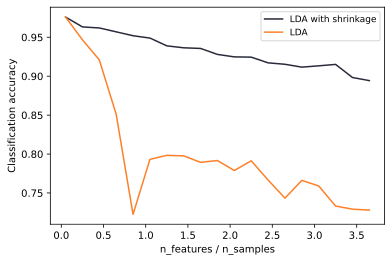

In [53]:
features_samples_ratio = np.array(n_features_range) / n_train

fig, axes = plt.subplots(1, 1, figsize=(6, 4))
axes.plot(features_samples_ratio, acc_clf1, linewidth=1.5,
             label="LDA with shrinkage", color='#282A3A')
axes.plot(features_samples_ratio, acc_clf2, linewidth=1.5,
             label="LDA", color='#FD7F28')

axes.set_xlabel('n_features / n_samples')
axes.set_ylabel('Classification accuracy')
axes.legend(prop={'size': 9});

<div class="admonition tip">
<p class="admonition-title">
Tips
</p>
<p>
<ul>
<li>
The above simulation also shows LDA works well for the high dimension data
as long as <b>one feature</b> could give the clear boundary of classification. 
</li>
<li>
The LDA model from sklearn performances way faster than the one we wrote it
</li>
</ul>
</p>
</div>


### Computations for LDA

As a lead-in to the next topic, we briefly digress on the computations required for LDA and especially QDA. Their computations are simplified by diagonalizing $\hat{\mathbf{\Sigma}}$ or $\hat{\boldsymbol{\Sigma}}_k$. For the latter, suppose we compute the eigendecomposition for each $\hat{\boldsymbol{\Sigma}}_k=\mathbf{U}_k \mathbf{D}_k \mathbf{U}_k^T$, where $\mathbf{U}_k$ is $p \times p$ orthonormal, and $\mathbf{D}_k$ a diagonal matrix of positive eigenvalues $d_{k \ell}$. Then the ingredients for $\delta_k(x)(4.12)$ are
- $\left(x-\hat{\mu}_k\right)^T \hat{\boldsymbol{\Sigma}}_k^{-1}\left(x-\hat{\mu}_k\right) = \left[\mathbf{U}_k^T\left(x-\hat{\mu}_k\right)\right]^T \mathbf{D}_k^{-1}\left[\mathbf{U}_k^T\left(x-\hat{\mu}_k\right)\right]$;
- $\log \left|\hat{\boldsymbol{\Sigma}}_k\right|=\sum_{\ell} \log d_{k \ell}$.

In light of the computational steps outlined above, the LDA classifier can be implemented by the following pair of steps:

- Sphere the data with respect to the common covariance estimate $\hat{\mathbf{\Sigma}}$ : $X^* \leftarrow \mathbf{D}^{-\frac{1}{2}} \mathbf{U}^T X$, where $\hat{\boldsymbol{\Sigma}}=\mathbf{U D U}^T$. The common covariance estimate of $X^*$ will now be the identity.
- Classify to the closest class centroid in the transformed space, modulo the effect of the class prior probabilities $\pi_k$.

### Reduced-Rank LDA

When $p > K$, we do not have to feed in all dimensions of features as we
just need input space lie in an affine subspace $\leq K-1$, and if $p$ is 
much larger than $K$, this will be a considerable drop in dimension. 
Moreover, in locating the closest centroid, we can ignore distances 
orthogonal to this subspace, since they will contribute equally to each class. 
Thus we might just as well project the $X^*$ onto this centroid-spanning 
subspace $H_{K-1}$, and make distance comparisons there.

Therefore there is a fundamental dimension reduction in LDA, namely, 
that we need only consider the data in a subspace of dimension at 
most $K-1$. If  $K=3$, e.g., this could allow us to view the data 
in $\mathbb{R}^2$, color-coding the classes. In doing so we would not have 
relinquished any of the information needed for LDA classification.


Before we go through the algorithms, let's examine an example. For a wine classification problem with three different types of wines and 13 input variables, the plot visualizes the data in two discriminant coordinates found by LDA. In this two-dimensional space, the classes can be well-separated. In comparison, the classes are not as clearly separated using the first two principal components found by PCA.

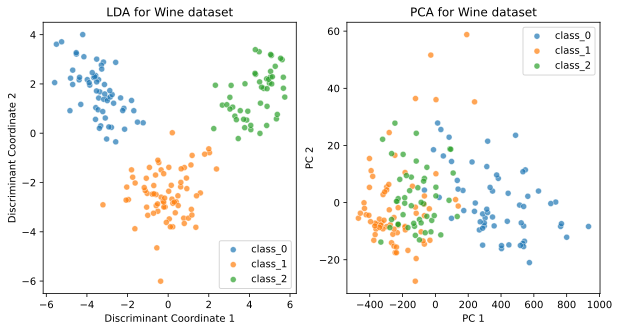

In [54]:
from sklearn import datasets  # import the dataset
from sklearn.decomposition import PCA

wine = datasets.load_wine()
X = wine.data
y = wine.target
target_names = wine.target_names

X_r_lda = LinearDiscriminantAnalysis(
    n_components=2
    ).fit(X, y).transform(X)
X_r_pca = PCA(n_components=2).fit(X).transform(X)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, target_name in zip([0, 1, 2], target_names):
    sns.scatterplot(
        x=X_r_lda[y == i, 0], y=X_r_lda[y == i, 1], 
        label=target_name, 
        alpha=0.7, ax=axes[0]
        )
    sns.scatterplot(
        x=X_r_pca[y == i, 0], y=X_r_pca[y == i, 1], 
        label=target_name, 
        alpha=0.7, ax=axes[1]
    )
sns.move_legend(axes[0], 'lower right')
axes[0].set_title('LDA for Wine dataset')
axes[1].set_title('PCA for Wine dataset')
axes[0].set_xlabel('Discriminant Coordinate 1')
axes[0].set_ylabel('Discriminant Coordinate 2')
axes[1].set_xlabel('PC 1')
axes[1].set_ylabel('PC 2'); 

<div class="admonition tip">
<p class="admonition-title">
Tips
</p>
<p>
We have observed from the previous section that LDA makes distance comparison in the space spanned by different <b>class means</b>. Two distinct points lie on a 1d line; three distinct points lie on a 2d plane. 
</p>
</div>

For the data with $K$ classes, all means lie on a hyperplane with dimension
at most $(K-1)$. In particular, the subspace spanned by the means is

$$H_{K-1} = \mu_1 \bigoplus \text{span}\{\mu_i - \mu_1, 2 \leq i \leq K\}$$

When making distance comparison in this space, distances orthogonal to this subspace would add no information since they contribute equally for each class. Hence, by restricting distance comparisons to this subspace only would not lose any information useful for LDA classification.

That means, we can safely transform our task from a $p$-dimensional problem to a
$(K-1)$-dimensional problem by an orthogonal projection of the data onto this
subspace. 

How could we find the _optimal subspace_ then? Fisher defined optimal to
mean that the _projected centroids were spread out as much as possible in
terms of variance_. This means we cover more data in this optimal subspace and
used the maximum information we have:

- A large variance among the dataset classes (spread out)
- A small variance within each of the dataset classes (cluster within class)

In summary then, finding the sequences of optimal subspaces for LDA involves
the following steps ($\hat{\mu}_k$ is a column vector denoting the mean vector of class $k$):

- compute the $K \times p$ matrix of class centroids $M$ and the common (or pooled)
covariance matrix $W$ (for within-class covariance);

$$W = \sum_{k=1}^K \sum_{g_i=k} (x_i - \hat{\mu}_k)(x_i-\hat{\mu}_k)^T$$

- compute $M^* = MW^{-1/2}$ using the eigen-decomposition of $W$
- compute $B^*$, the covariance matrix of $M^*$ (B for _between-class_ covariance)

$$B^*=\sum_{k=1}^K (\hat{\mu}_k - \hat{\mu}^*)(\hat{\mu}_k - \hat{\mu}^*)^T$$

where

$$\hat{\mu}^* = \sum_{k=1}^K \pi_k \hat{\mu}_k = \text{sample mean}$$

- PCA: obtain L eigenvectors  $v_l^*$ in $V^*$ of $B^* = V^*D_B V^{*T}$ corresponding
to the $L$ largest eigenvalues. These define the coordinates of the optimal 
subspace. 

- Obtain $L$ new (discriminant) variables $Z_l = (W^{-1/2} v_l^*)^TX, for $l = 1, \cdots, L$

Through this procedure, we reduce our data from $X_{(N \times p)}$ to 
$Z_{(N \times L)}$ and dimension from $p$ to $L$. Discriminant 
coordinate 1 and 2 in the previous wine plot are found by setting $L=2$. 
Repeating the previous LDA procedures for classification using the 
new data, $Z$, is called the reduced-rank LDA.

Fisher does not make any assumptions about the distribution of the data. Instead, he tries to find a “sensible” rule so that the classification task becomes easier. In particular, Fisher finds a linear combination of the original data, $Z=a^TX$, 
where the between-class variance, $B=cov(M)$, is maximized relative to 
the within-class variance, $W$.

The following figure shows why this rule makes intuitive sense. The rule sets out to find a direction, $a$, where, after projecting the data onto that direction, class means have maximum separation between them, and each class has minimum variance within them. The projection direction found under this rule, shown in the right plot, makes classification much easier.

![fisher-LDA](https://yangxiaozhou.github.io/assets/2019-10-02/sensible_rule.png)

### Fisher's formula 

Fisher constructs two numbers:

\begin{aligned}
R \ni d_B & := \mathbf{a}^T \mathbf{B a} \\
R \ni d_W & := \mathbf{a}^T \mathbf{W a}
\end{aligned}

He wants to maximize $d_B$ (spread-out) and minimize $d_W$ (cluster within class).
We can merge those two optimization problems as a regularized optimization
problem:

$$\max_a = d_B(a) - d_W(a) $$

or 
:
$$
\max _{\mathbf{a}} \frac{\mathbf{a}^T \mathbf{B a}}{\mathbf{a}^T \mathbf{W a}} .
$$


The problem is equivalent to (see [proof](https://arxiv.org/abs/1906.09436))
$$
\begin{aligned}
&\max _{\mathbf{a}} \mathbf{a}^T \mathbf{B a} \\
&\text { s.t. } \mathbf{a}^T \mathbf{W} \mathbf{a}=1
\end{aligned}
$$
since the scaling of a does not affect the solution. Now, we could form the
Lagrangian as 

$$L = a^T B a - \lambda (a^T W a - 1)$$

The solution is 

$$Ba = \lambda W a  \implies W^{-1}B a = \lambda a$$

which is the eigenvalue and eigenvector problem and $a$ is the eigenvector of
$W^{-1}B$. Because $W$ might be singular and not invertible, we will stretch
the diagonal of $W$ slightly to make it full rank and invertible:

$$a = \text{eig} [(W+\epsilon I)^{-1} B] $$

where $a$ is referred to as the _Fisher direction_ or _Fisher axis_. 

To summarize the developments so far:

- Gaussian classification with common covariances leads to linear decision boundaries. Classification can be achieved by sphering the data
with respect to $W$, and classifying to the closest centroid (modulo
$\log \pi k$) in the sphered space.

- Since only the relative distances to the centroids count, one can confine the data to the subspace spanned by the centroids in the sphered
space.

- This subspace can be further decomposed into successively optimal
subspaces in term of centroid separation. This decomposition is identical to the decomposition due to Fisher

Once we transferred our dataset, we could classify according to the class
$j = 1, \cdots, K$ for which

$$\frac{1}{2} || \tilde{x} - \tilde{\mu} ||^2 - \log \hat{\pi}_j$$

is smalles, where $\tilde{x} = Ax \in R^{K-1}$ and $\tilde{\mu} = A \hat{\mu}_j$

In [55]:
class FDA:
    """
    Fisher Discriminant Analysis
    """

    def __init__(self, n_components=None, kernel=None):
        """
        n_components: the number of components (or coordinates)
        kernel: kernel of X
        """
        self.is_model_fitted = False
        self.n_components = n_components 
        # projection matrix 
        self.proj_matrix = None
        self.class_categories = []
        self.class_priors = {}
        self.class_means = {}
        if kernel is not None:
            self.kernel = kernel 
        else:
            self.kernel = 'linear'
            
    def fit(self, X, y):
        """
        X: N by p matrix
        y: N by 1 matrix
        """
        # get the unique classes
        self.class_categories = np.unique(y)
        # feature dimension
        p = X.shape[1]
        N = X.shape[0]
        K = len(self.class_categories)
        # estimate sample mean 
        sample_mean = X.mean(axis=0).reshape(p, 1)
        
        # estimate between class covariance 
        # between scatter matrix B or S, p by p 
        B = np.zeros((p, p))
        for k in self.class_categories:
            class_k_row_idx = np.where(y==k)[0]
            n_k = len(class_k_row_idx)
            X_filtered_class_k = X[class_k_row_idx, :]
            self.class_priors[k] = float(n_k)/N
            self.class_means[k] = np.mean(
                X_filtered_class_k, axis=0
                ).reshape(p, 1)
            between_mean_diff = self.class_means[k] - sample_mean
            # calculate B 
            # some people use weighted one
            # n_k = len(class_k_row_idx)
            # B += n_k * between_mean_diff @ between_mean_diff.T
            B += between_mean_diff @ between_mean_diff.T
            
        # estimate pooled covariance W
        class_k_covs = {}
        W = 0
        for k in self.class_categories:
            class_k_row_idx = np.where(y==k)[0]
            X_filtered_class_k = X[class_k_row_idx, :]
            # each column as a variable 
            class_k_covs[k] = np.cov(X_filtered_class_k, rowvar=False)
            # calculate pooled covariance
            W += class_k_covs[k] * self.class_priors[k]
            
        # rank the eigenvalues 
        epsilon = 0.00001
        # do not use eigh, it gives wrong eigenvectors
        eig_val, eig_vec = np.linalg.eig(
            np.linalg.pinv(W+epsilon*np.eye(W.shape[0])) @ B
        )
        # only take real values 
        eig_val = eig_val.real
        eig_vec = eig_vec.real 
        # sort eigenvalues in descending order
        eig_idx = eig_val.argsort()[::-1]
        eig_val = eig_val[eig_idx]
        eig_vec = eig_vec[:, eig_idx]
        # get the coordinate matrix 
        if self.n_components is not None:
            U = eig_vec[:, :self.n_components]
        else:
            U = eig_vec[:, :K-1]
            
        self.proj_matrix = U

        self.is_model_fitted = True
        
    def transform(self, X):
        """
        X: N by p matrix 
        projection matrix is p by K-1
        """
        if not self.is_model_fitted:
            raise NameError('Please fit the model first')

        return X @ self.proj_matrix

    def predict(self, X_transformed):
        """
        X_transformed: sample size by p matrix [N, n_components <= K-1]
        return: the predicted class [N, 1] matrix
        """
        y_est = np.apply_along_axis(
            self.__classify, 1, X_transformed
        )

        return y_est

    def __classify(self, x_transformed):
        """
        Private method
        x_transformed: 
            feature vector for one observation [1, K-1] dimension
        Returns: classified category
        """
        if not self.is_model_fitted:
            raise NameError('Please fit the model first')
        
        # calculate the determinant score
        classified_scores = {}
        for k in self.class_categories:
            # transform the mean, y by p - p by k-1
            transformed_mean = self.class_means[k].T @ self.proj_matrix
            mean_distance = np.linalg.norm(
                x_transformed - transformed_mean
                )
            prior_hat = self.class_priors[k]
            score =  0.5*np.square(mean_distance)-np.log(prior_hat)
            classified_scores[k] = score

        # !Warning: we want the minimal score now 
        return min(classified_scores, key=classified_scores.get)

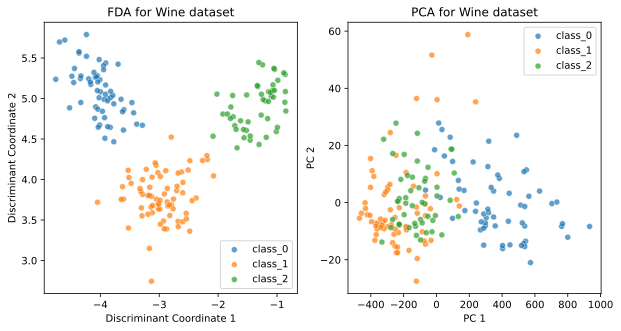

In [56]:
# test the FDA
from sklearn import datasets  # import the dataset
from sklearn.decomposition import PCA

wine = datasets.load_wine()
X = wine.data
y = wine.target
target_names = wine.target_names
# reduced dimension 
wine_fda = FDA(n_components=2)
wine_fda.fit(X, y)
X_r_fda = wine_fda.transform(X)
X_r_pca = PCA(n_components=2).fit(X).transform(X)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, target_name in zip([0, 1, 2], target_names):
    sns.scatterplot(
        x=X_r_fda[y == i, 0], y=X_r_fda[y == i, 1], 
        label=target_name, 
        alpha=0.7, ax=axes[0]
        )
    sns.scatterplot(
        x=X_r_pca[y == i, 0], y=X_r_pca[y == i, 1], 
        label=target_name, 
        alpha=0.7, ax=axes[1]
    )
sns.move_legend(axes[0], 'lower right')
axes[0].set_title('FDA for Wine dataset')
axes[1].set_title('PCA for Wine dataset')
axes[0].set_xlabel('Discriminant Coordinate 1')
axes[0].set_ylabel('Discriminant Coordinate 2')
axes[1].set_xlabel('PC 1')
axes[1].set_ylabel('PC 2'); 

In [57]:
# figure 4.10
dimension = range(1, 11)
train_mis_rate = []
test_mis_rate = []
# construct x and y
vowel_X = vowel.iloc[:, 1:].values
vowel_y = vowel.iloc[:, 0].values.reshape(-1, 1)
vowel_test_X = vowel_test.iloc[:, 1:].values
for d in dimension:
    vowel_fda = FDA(n_components=d)
    vowel_fda.fit(vowel_X, vowel_y)
    vowel_X_transformed = vowel_fda.transform(vowel_X)
    y_pred = vowel_fda.predict(vowel_X_transformed)
    # accuracy rate
    acc_rate = sum(vowel['y'] == y_pred) / vowel.shape[0]
    train_mis_rate.append(1-acc_rate)
    vowel_test_X_transformed = vowel_fda.transform(vowel_test_X)
    y_pred = vowel_fda.predict(vowel_test_X_transformed)
    acc_rate = sum(vowel_test['y'] == y_pred) / vowel_test.shape[0]
    test_mis_rate.append(1-acc_rate)

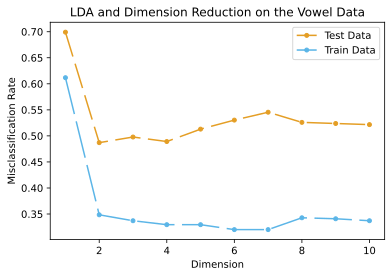

In [58]:
# figure 4.10
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
axes.plot(
    dimension, test_mis_rate, 
    color='#E49E25',  linestyle='--', marker='o',
    markersize=4, dashes=(17, 5),
    label='Test Data'
    )
axes.plot(
    dimension, train_mis_rate, 
    color='#5BB5E7', linestyle='--', marker='o',
    markersize=4, dashes=(25, 5),
    label='Train Data'
    )
axes.set_title("LDA and Dimension Reduction on the Vowel Data")
axes.set_ylabel("Misclassification Rate")
axes.set_xlabel("Dimension")
axes.legend();

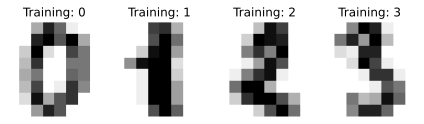

In [59]:
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

digits = datasets.load_digits()

images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)
    plt.tight_layout()

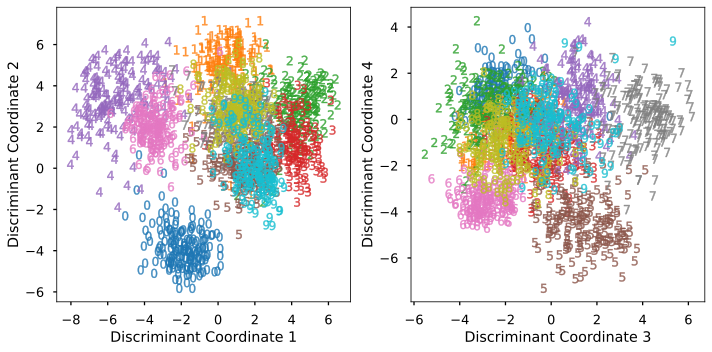

In [60]:
X = digits.data
n_samples = X.shape[0]
y = digits.target
target_names = digits.target_names

# Create a classifier: a Fisher's LDA classifier
lda = LinearDiscriminantAnalysis(
    n_components=4, solver='eigen', shrinkage=0.1
    )

# Train lda on the first half of the digits
lda = lda.fit(X[:n_samples // 2], y[:n_samples // 2])
X_r_lda = lda.transform(X)

# Visualize transformed data on learnt discriminant coordinates
with plt.style.context('seaborn-talk'):
    fig, axes = plt.subplots(1,2,figsize=[10,5])
    for i, target_name in zip([0,1,2,3,4,5,6,7,8,9], target_names):
        axes[0].scatter(
            X_r_lda[y == i, 0], X_r_lda[y == i, 1], 
            alpha=.8, label=target_name,
            marker='$%.f$'%i)
        axes[1].scatter(
            X_r_lda[y == i, 2], X_r_lda[y == i, 3], 
            alpha=.8, label=target_name,
            marker='$%.f$'%i)
    axes[0].set_xlabel('Discriminant Coordinate 1')
    axes[0].set_ylabel('Discriminant Coordinate 2')
    axes[1].set_xlabel('Discriminant Coordinate 3')
    axes[1].set_ylabel('Discriminant Coordinate 4')
    plt.tight_layout()

The above plot allows us to interpret the trained LDA classifier. For example, coordinate 1 helps to contrast 4’s and 2/3’s while coordinate 2 contrasts 0’s and 1’s. Subsequently, coordinate 3 and 4 help to discriminate digits not well-separated in coordinate 1 and 2. We test the trained classifier using the other half of the dataset. The report below summarizes the result.

In [61]:
n_samples = len(X)

# Predict the value of the digit on the second half:
expected = y[n_samples // 2:]
predicted = lda.predict(X[n_samples // 2:])

report = metrics.classification_report(expected, predicted)
print("Classification report:\n%s" % (report))

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        88
           1       0.94      0.88      0.91        91
           2       0.97      0.90      0.93        86
           3       0.91      0.95      0.92        91
           4       1.00      0.91      0.95        92
           5       0.93      0.96      0.94        91
           6       0.97      0.99      0.98        91
           7       0.98      0.97      0.97        89
           8       0.91      0.85      0.88        88
           9       0.79      0.93      0.86        92

    accuracy                           0.93       899
   macro avg       0.94      0.93      0.93       899
weighted avg       0.93      0.93      0.93       899



The highest precision is 99%, and the lowest is 77%, a decent result knowing that the method was proposed some 70 years ago. Besides, we have not done anything to make the procedure better for this specific problem. For example, there is collinearity in the input variables, and the shrinkage parameter might not be optimal.

## 4.4 Logistic Regression

The logistic regression model arises from the desire to model the posterior probabilities of the $K$ classes via linear functions in $x$, ensuring the natural properties of the probability: They sum to one and remain in $[0,1]$.

The model has the form

\begin{aligned}
\log\frac{\text{Pr}(G=1|X=x)}{\text{Pr}(G=K|X=x)} &= \beta_{10} + \beta_1^Tx \\
\log\frac{\text{Pr}(G=2|X=x)}{\text{Pr}(G=K|X=x)} &= \beta_{20} + \beta_2^Tx \\
&\vdots \\
\log\frac{\text{Pr}(G=K-1|X=x)}{\text{Pr}(G=K|X=x)} &= \beta_{(K-1)0} + \beta_{K-1}^Tx \\
\end{aligned}

The model is specified in terms of $K-1$ log-odds or logit transformations, reflecting the constraint that the probabilities sum to one. The choice of denominator ($K$ in this case) is arbitrary in that the estimates are equivalent under this choice.

To emphasize the dependence on the entire parameter set $\theta = \left\lbrace \beta_{10}, \beta_1^T, \cdots, \beta_{(K-1)0}, \beta_{K-1}^T\right\rbrace$, we denote the probabilities

\begin{equation}
\text{Pr}(G=k|X=x) = p_k(x;\theta)
\end{equation}

A simple calculation shows that

\begin{aligned}
\text{Pr}(G=k|X=x) &= \frac{\exp(\beta_{k0}+\beta_k^Tx)}{1+\sum_{l=1}^{K-1}\exp(\beta_{l0}+\beta_l^Tx)}, \text{ for } k=1,\cdots,K-1, \\
\text{Pr}(G=K|X=x) &= \frac{1}{1+\sum_{l=1}^{K-1}\exp(\beta_{l0}+\beta_l^Tx)},
\end{aligned}

It is better to write it as the following form:

\begin{aligned}
\text{Pr}(G=k|X=x) &= \frac{\exp(\beta_{k0}+\beta_k^Tx)}{\exp(0)+\sum_{l=1}^{K-1}\exp(\beta_{l0}+\beta_l^Tx)} \\
& = \frac{\exp(\beta_{k0}+\beta_k^Tx)}{\sum_{l=0}^{K-1}\exp(\beta_{l0}+\beta_l^Tx)} \\
\text{Pr}(G=K|X=x) &= \frac{\exp(0)}{\sum_{l=0}^{K-1}\exp(\beta_{l0}+\beta_l^Tx)}
\end{aligned}

and they clearly sum to one.

When $K=2$, this model is especially simple, since there is only a single linear function.

### Fitting logistic regression models

Logistic regression models are usually fit by maximum likelihood, using the conditional likelihood of $G$ given $X$. Since $\text{Pr}(G|X)$ completely specifies the conditional distribution, the *multinomial* distribution is appropriate.

The log-likelihood for $N$ observation is

\begin{equation}
l(\theta) = \sum_{i=1}^N \log p_{g_i}(x_i;\theta),
\end{equation}

where $p_k(x_i;\theta) = \text{Pr}(G=k|X=x_i;\theta)$ 


We discuss in detail the __two-class case__, sine the algorithms simplify considerably. It is convenient to code the two-class $g_i$ via a $0/1$ response $y_i$, where $y_i=1$ when $g_i=1$, and $0$ otherwise. Then we can let

\begin{aligned}
p_1(x;\theta) &= p(x;\theta) , \\
p_2(x;\theta) &= 1- p(x;\theta). \\
\end{aligned}

And it is easy to show for _two-class_ case, we have

$$  \frac{p(x_i;\beta)}{1-p(x_i;\beta)} = \beta^Tx_i$$

The log-likelihood can be written

\begin{aligned}
l(\beta) &= \sum_{i=1}^N \left\lbrace y_i\log p(x_i;\beta) + (1-y_i)\log(1-p(x_i;\beta)) \right\rbrace \\
& = \sum_{i=1}^N  \left\lbrace y_i [\log p(x_i;\beta) - \log(1-p(x_i;\beta)] + \log(1-p(x_i;\beta)) \right\rbrace \\ 
& = \sum_{i=1}^N  \left\lbrace y_i \log \frac{p(x_i;\beta)}{1-p(x_i;\beta)} + \log(1-p(x_i;\beta))  \right\rbrace \\ 
&= \sum_{i=1}^N \left\lbrace y_i\beta^Tx_i - \log(1+\exp(\beta^Tx)) \right\rbrace,
\end{aligned}

where $\beta^T = \lbrace \beta_{10}, \beta_1^T \rbrace$, and we assume that the vector of inputs $x_i$ includes the constant term 1 to acommodate the intercept.

To maximize the log-likelihood, we set its derivatives to zero. These *score* equations are

$$
\frac{\partial l(\beta)}{\partial\beta} = \sum_{i=1}^N x_i(y_i-p(x_i;\beta)) = 0,
$$

which are $p+1$ equations *nonlinear* in $\beta$. Notice that since $x_{i1} =1$, the first score equation specifies that

$$
\sum_{i=1}^N y_i = \sum_{i=1}^N p(x_i;\beta),
$$

implying that the *expected* number of class ones matches the observed number (and hence also class twos).

<div class="admonition tip">
<p class="admonition-title">
Tips
</p>
<p>
<ul>
<li>
For the case K = 2, we used the Sigmoid function;
</li>
<li>
For the cases of$K > 3, we will use softmax function and log likelihood function
will be different. 
</li>
</ul>
</p>
</div>

### Newton-Raphson algorithm for binary case

To solve the score equation, we use the Newton-Raphson algorithm, which requires the second-derivative or Hessian matrix

\begin{equation}
\frac{\partial^2 l(\beta)}{\partial\beta\partial\beta^T} = -\sum_{i=1}^N x_ix_i^T p(x_i;\beta)(1-p(x_i;\beta)).
\end{equation}

Starting with $\beta^{\text{old}}$, a single Newton update is

\begin{equation}
\beta^{\text{new}} = \beta^{\text{old}} - \left( \frac{\partial^2 l(\beta)}{\partial\beta\partial\beta^T} \right)^{-1} \frac{\partial l(\beta)}{\partial\beta},
\end{equation}

where the derivatives are evaluated at $\beta^{\text{old}}$.

### Iteration in matrix notation for binary case

Let
* $\mathbf{y}$ be the vector of $y_i$ values,
* $\mathbf{X}$ the $N\times (p+1)$ matrix of $x_i$ values,
* $\mathbf{p}$ the vector of fitted probabilities with $i$th element $p(x_i;\beta^{\text{old}})$, and
* $\mathbf{W}$ $N\times N$ diagonal matrix of weights with $i$th diagonal elements $p(x_i;\beta^{\text{old}})(1-p(x_i;\beta^{\text{old}}))$.

Then we have

\begin{aligned}
\frac{\partial l(\beta)}{\partial\beta} &= \mathbf{X}^T(\mathbf{y}-\mathbf{p}) \\
\frac{\partial^2l(\beta)}{\partial\beta\partial\beta^T} &= -\mathbf{X}^T\mathbf{WX},
\end{aligned}

and thus the Newton step is

\begin{aligned}
\beta^{\text{new}} &= \beta^{\text{old}} + (\mathbf{X}^T\mathbf{WX})^{-1}\mathbf{X}^T(\mathbf{y}-\mathbf{p}) \\
&= (\mathbf{X}^T\mathbf{WX})^{-1} \mathbf{X}^T\mathbf{W}\left( \mathbf{X}\beta^{\text{old}} + \mathbf{W}^{-1}(\mathbf{y}-\mathbf{p}) \right) \\
&= (\mathbf{X}^T\mathbf{WX})^{-1}\mathbf{X}^T\mathbf{W}\mathbf{z},
\end{aligned}

where we have re-expressed the Newton step as weighted least squares step, with the response

$$
\mathbf{z} = \mathbf{X}\beta^{\text{old}} + \mathbf{W}^{-1}(\mathbf{y}-\mathbf{p}),
$$

sometimes known as the *adjusted response*.


These equations for the Newton step get solved repeatedly, since at each iteration $p$ changes, and hence so does $\mathbf{W}$ and $\mathbf{z}$. This algorithm is referred to as *iteratively reweighted least squares* or IRLS, since each iteration solves the weighted least squares problem:

$$
\beta^{\text{new}} \leftarrow \arg\min_\beta (\mathbf{z}-\mathbf{X}\beta)^T\mathbf{W}(\mathbf{z}-\mathbf{X}\beta)
$$

It seems that $\beta=0$ is a good starting value, although convergence is never guaranteed. Typically the algorithm does converge, since the log-likelihood is concave, but overshooting can occur. In the rare cases that the log-likelihood decreases, step size halving will guarantee convergence.

### A simplified derivation for binary case

Use the sigmoid function we have:

$$p(x; \beta) = \sigma(z) = \frac{e^z}{1+e^z} = \frac{1}{1+ \exp(-z)}$$

where 

$$ z = X\beta := w\cdot x + b$$

The derivative of the sigmoid is very elegant:

$$\frac{d \sigma }{d z } = \sigma(z) [1- \sigma(z)]$$

Then, we have

\begin{aligned}
\frac{d p}{d \beta} & = \frac{d \sigma}{d z} \frac{d z}{d \beta} \\
                    & = \sigma(z) [1- \sigma(z)] X^T \\
                    & = p(x; \beta)[1 - p(x; \beta)] X^T
\end{aligned}

For the following equation,

$$
\frac{\partial l(\beta)}{\partial\beta} = \sum_{i=1}^N x_i(y_i-p(x_i;\beta))
$$ 

Its second derivative is easy to derive now:

$$
\frac{\partial^2 l(\beta)}{\partial\beta\partial\beta^T} = -\sum_{i=1}^N x_ix_i^T p(x_i;\beta)(1-p(x_i;\beta)).
$$

<div class="admonition tip">
<p class="admonition-title">
Tips
</p>
<p>
The neural network uses sigmoid and softmax functions a lot. Moreover,
the <i>loss</i> function is just the negativity of log-likelihood function. 
Therefore, we will go through those derivations. 
</p>
</div>

The first derivative takes a long time and has more equations. Nevertheless, we could still do it with several components.

For our log-likelihood function

$$
L(\beta) = \sum_{i=1}^N \left\lbrace y_i\log p(x_i;\beta) + (1-y_i)\log(1-p(x_i\beta)) \right\rbrace
$$

It is easy to have

$$\frac{d L}{d p} = \frac{y}{p} - \frac{1-y}{1-p}$$

We have already shown :

$$\frac{d p}{d \beta} = p(x; \beta)[1 - p(x; \beta)] X^T =  p(1 - p)X^T$$

Now, let's put them together

\begin{aligned}
\frac{dL}{d \beta} & = \frac{d L}{d p} \frac{dp}{d \beta} \\
                   & = \big [ \frac{y}{p} - \frac{1-y}{1-p}  \big ] [p(1 - p)X^T] \\
                   & = \frac{y-p}{p(1-p)}[p(1 - p)X^T] \\
                   & = (y-p)X^T
\end{aligned}

which is equivalent to 

$$
\frac{\partial l(\beta)}{\partial\beta} = \sum_{i=1}^N x_i(y_i-p(x_i;\beta))
$$ 

<div class="admonition tip">
<p class="admonition-title">
Tips
</p>
<p>
Since p, 1-p and p(1-p) are scalar, that's why we have to take the diagnonal
element when we implement the matrix computation. 
</p>
</div>

In [62]:
# implement a simple logistic regression for binary case 
# the close form of solution 
def sigmoid(x):
    # sigmoid function
    return 1/(1+np.exp(-x))


def gradient(x, y, beta):
    """
    The first derivative of log-likelihood function
    Based on equation (4.24 or 4.21)

    x: n by p+1 matrix (with constant)
    y: n by 1 vector
    beta: p+1 by 1 vector

    Return [(p+1) by 1 row vector]
    """
    z = x @ beta  # n by 1 vector
    phat = sigmoid(z)  # n by 1 vector 
    return x.T @ (y - phat)  


def hessian(x, beta):
    """
    The second derivative of log-likelihood function
    Based on equation (4.25 or 4.23)
    x: n by p+1 matrix 
    beta: parameters, p+1 by 1
    
    Return: p+1 by p+1 matrix 
    """
    z = x @ beta  # n by 1 vector
    phat = sigmoid(z)  # n by 1 vector 
    # flatten the phat vector
    # ! Important step
    phat = phat.flatten() 
     # create the diagnoal matrix filled with 0s
    w = np.diag(phat*(1-phat))  # n by n matrix 
    
    return - x.T @ w @ x


def newton(x, y, beta_0, G, H, epsilon, max_iter):
    """
    Newton's method to estimate parameters
    beta_0: initial values p+1 by 1 
    epsilon: convergence rate 
    G: gradient function
    H: hessian function 
    """

    # !Important to copy, otherwise all values will be changed
    beta = beta_0.copy()
    # initialize the different of beta_old and new
    delta = 1  # shoul be positive
    iteration = 0 
    while delta > epsilon and iteration < max_iter:
        # save the orginal value before updating 
        beta_old = beta.copy()
        # update beta, [p+1, p+1] @ [p+1, 1] 
        beta -= np.linalg.inv(H(x, beta)) @ G(x, y, beta)
        iteration += 1 

    # calculate the standard error
    # std err is sqrt of diagonal of inverse of negative hessian
    neg_hessian = -H(x, beta)
    neg_hessian_inv = np.linalg.inv(neg_hessian)
    std_err = np.sqrt(np.diag(neg_hessian_inv))

    # one could also estimate the standard error by 
    # doing boostrapping (100 estimation with different samples)

    return beta, std_err

<div class="admonition tip">
<p class="admonition-title">
Tips
</p>
<p>
Later we will just use loss function and gradient descent method to estimate
coefficients, which will use more iterations as it is dealing with the
first order derivative. 
</p>
</div>

###  Example: South African heart disease (binary case)

Here we present an analysis of binary data to illustrate the traditional
statistical use of the logistic regression model.

In [63]:
# read heart disease data 
sa_heart = pd.read_csv('./data/heart/SAheart.data', index_col=0)
sa_heart.head()

sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  \
row.names                                                                    
1          160    12.00  5.73      23.11  Present     49    25.30    97.20   
2          144     0.01  4.41      28.61   Absent     55    28.87     2.06   
3          118     0.08  3.48      32.28  Present     52    29.14     3.81   
4          170     7.50  6.41      38.03  Present     51    31.99    24.26   
5          134    13.60  3.50      27.78  Present     60    25.99    57.34   

           age  chd  
row.names            
1           52    1  
2           63    1  
3           46    0  
4           58    1  
5           49    1

In [64]:
# we will only use four variables 
sa_heart.pop('adiposity')
sa_heart.pop('typea')
# creat dummy for famhist
sa_heart['famhist'] = sa_heart['famhist'].map(
    {
        'Present': 1, 'Absent': 0
    }
)
sa_heart.head()

sbp  tobacco   ldl  famhist  obesity  alcohol  age  chd
row.names                                                         
1          160    12.00  5.73        1    25.30    97.20   52    1
2          144     0.01  4.41        0    28.87     2.06   63    1
3          118     0.08  3.48        1    29.14     3.81   46    0
4          170     7.50  6.41        1    31.99    24.26   58    1
5          134    13.60  3.50        1    25.99    57.34   49    1

In [65]:
# prepare x and y
sa_df_y = sa_heart.pop('chd')
sa_y = sa_df_y.values.reshape(-1, 1)
sa_x = sa_heart.values

In [66]:
# plot the grapha
colors = sa_df_y.apply(lambda y: 'C1' if y else 'C0')
pd.plotting.scatter_matrix(sa_heart, color=colors, figsize=(10, 10));

In [67]:
# fit logistic model
n, p = sa_x.shape
x_const = np.hstack([np.ones((n, 1)), sa_x])
beta_initial = np.zeros((p+1, 1))
beta_est, std_errors = newton(
    x_const, sa_y, beta_initial, gradient, hessian,
    1e-6, 100
)

In [68]:
print('{0:>15} {1:>15} {2:>15} {3:>15}'.format('Term', 'Coefficient',
                                               'Std. Error', 'Z Score'))
print('-'*64)
table_term = ['intercept'] + list(sa_heart.columns)
for term, coeff, std_err in zip(table_term, beta_est, std_errors):
    print('{0:>15} {1:>15.3f} {2:>15.3f} {3:>15.3f}'.format(
        term, float(coeff), float(std_err),
        float(coeff)/float(std_err)
        ))

           Term     Coefficient      Std. Error         Z Score
----------------------------------------------------------------
      intercept          -4.130           0.964          -4.283
            sbp           0.006           0.006           1.023
        tobacco           0.080           0.026           3.034
            ldl           0.185           0.057           3.218
        famhist           0.939           0.225           4.177
        obesity          -0.035           0.029          -1.187
        alcohol           0.001           0.004           0.136
            age           0.043           0.010           4.181



When we calculate the second derivate, we could get the Fisher informtion

$$I(\beta) = - E [\frac{\partial^2l(\beta)}{\partial\beta\partial\beta^T}]= E[\mathbf{X}^T\mathbf{WX}]$$

The approximate sample distribution of $\hat{\beta}$ for large $n$ is 

$$N[\beta, (X^TWX)^{-1}]$$

How does one interpret $\textsf{tobacco}$ coefficient of $0.081$ ($\text{Std. Error} = 0.026$), for example?

An increase of $1\text{kg}$ in lifetime tobacco usage accounts for an increase in the odds of coronary heart disease of $\exp(0.081)=1.084$ or $8.4\%$.

Incorporating the standard error we get an approximate $95\%$ confidence interval of

$$
\exp(0.081 \pm 2\times 0.026) = (1.03, 1.14).
$$

We see that some of the variables have nonlinear effects, and when modeled appropriately, are not excluded from the model.

## LDA or Logistic Regression 

It is generally felt that logistic regression is a safer, more robust bet 
than the LDA model, relying on fewer assumptions. It is our experience that the models give very similar results, even when LDA is used inappropriately, such as with qualitative predictors.

LDA could be also used as a dimension reduction tool. 

## References

1. [ML-library](https://github.com/christopherjenness/ML-lib)
2. [RLDA](https://online.stat.psu.edu/stat508/lesson/8/8.3/8.3.12)
3. [LDA Exlained](https://yangxiaozhou.github.io/data/2019/10/02/linear-discriminant-analysis.html)
4. [PracticalML](https://www.biostat.jhsph.edu/~hcorrada/PracticalML/)
5. [Tübingen ML](https://dkobak.github.io/)
6. [an illustration](https://sthalles.github.io/fisher-linear-discriminant/)
7. [FDA-Python](https://github.com/bghojogh/Fisher-Discriminant-Analysis)
8. [tutorial](https://usir.salford.ac.uk/id/eprint/52074/1/AI_Com_LDA_Tarek.pdf)
9. [CMU Notes](https://www.stat.cmu.edu/~ryantibs/datamining/lectures/21-clas2.pdf)
10. [Reduced-Rank LDA R Code](https://waxworksmath.com/Authors/G_M/Hastie/WWW/chapter_4.html)
11. [Statistical Inference](https://web.stanford.edu/class/archive/stats/stats200/stats200.1172/lectures.html)